# Testing the RAG implementation

Purpose of the notebook: test which retrieval queries and generation prompts work best, which embedding models / LLM models, PDF text extraction approaches perform best
Evaluate on a manually coded validation set based on three sample reports

Evaluate
1.  RAG retrieval
2.  RAG generation

## Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from thefuzz import process, fuzz
import re
import urllib3
import pymupdf
import requests
import os
import io
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_experimental.text_splitter import SemanticChunker
from langchain_experimental.text_splitter import SemanticChunker
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder


import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

# import OpenAI API key from environment variable
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

[nltk_data] Downloading package punkt to
[nltk_data]     /home/tu/tu_tu/tu_zxowg46/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/tu/tu_tu/tu_zxowg46/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Select sample reports
Source: Sustainability Reporting Navigator (crowd-source list of CSRD-compliant reports for fiscal years starting on 01/01/2024)

Download CSV with information on all reports on the 08/04/2025 https://www.sustainabilityreportingnavigator.com/#/csrdreports 

In [2]:
# Open the csv data file
reports_24 = pd.read_csv('esg_reports_2024.csv')
print(len(reports_24))

277


In [3]:
# randomly select 3 reports from 2024
sample = reports_24.sample(n=3, random_state=3)
sample.head()

,Unnamed: 0,company_withAccessInfo,link,country,sector,industry,publication date,pages PDF,auditor
220,19,Continental AG,https://annualreport.continental.com/2024/en/s...,Germany,Transportation,Auto Parts,2025-03-18,125,PwC
58,266,Schneider Electric*,https://www.se.com/ww/en/assets/564/document/5...,France,Resource Transformation,Electrical & Electronic Equipment,2025-03-26,186,PwC & Mazars
89,103,Philips,https://www.results.philips.com/publications/a...,Netherlands,Infrastructure,Electric Utilities & Power Generators,2025-02-21,85,EY


## Manually hand code ground truth = validation set

In [4]:
validation_set = pd.read_excel('validation_dataset.xlsx')
print(validation_set.head())

              report_name query  \
0      ContinentalAG_2024  S1_E   
1  SchneiderElectric_2024  S1_E   
2      ContinentalAG_2024  S1_D   
3      ContinentalAG_2024  S1_A   
4  SchneiderElectric_2024  S1_F   

                                                text page_number  
0  In accordance with Section 76 (4) AktG, the Ex...          27  
1  Our 2025 sustainability commitments\nWith less...          33  
2  The globally applicable Code of\nConduct provi...          41  
3  The globally applicable Code of\nConduct provi...          41  
4  Our Speak Up Mindset\nSchneider Electric emplo...          41  


In [5]:
# print how many text chunks per query, per report name
print(validation_set.groupby(['query', 'report_name' ]).size())

query  report_name           
S1_A   ContinentalAG_2024        22
       SchneiderElectric_2024    24
S1_B   ContinentalAG_2024        14
       SchneiderElectric_2024     4
S1_C   ContinentalAG_2024        19
       SchneiderElectric_2024    18
S1_D   ContinentalAG_2024        23
       SchneiderElectric_2024    10
S1_E   ContinentalAG_2024        12
       SchneiderElectric_2024    24
S1_F   ContinentalAG_2024        15
       SchneiderElectric_2024    23
S1_G   ContinentalAG_2024         5
       SchneiderElectric_2024     8
dtype: int64


Text(0.5, 1.0, 'Distribution of Text Chunk Lengths (Characters)')

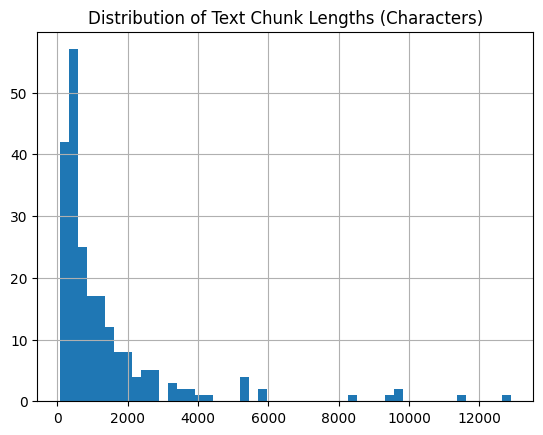

In [15]:
# graph the number of characters per text chunk
validation_set['text_length'] = validation_set['text'].apply(lambda x: len(x))
validation_set['text_length'].hist(bins=50)
plt.title('Distribution of Text Chunk Lengths (Characters)')

/tmp/ipykernel_2126613/3170922132.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Report Name')


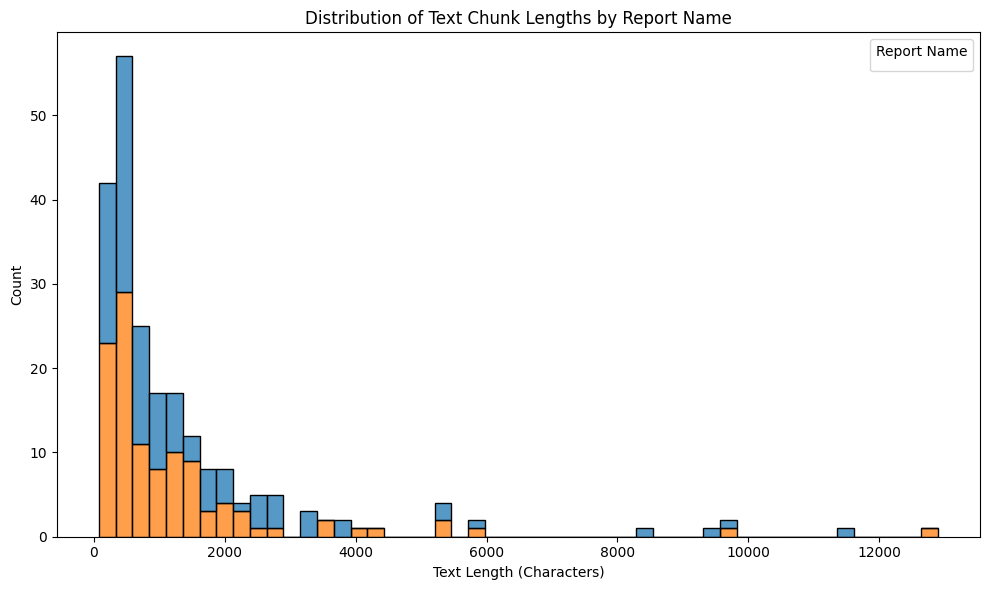

In [16]:
# Compute text lengths
validation_set['text_length'] = validation_set['text'].apply(len)

# Set up the figure
plt.figure(figsize=(10, 6))

# Use seaborn to plot the histogram by report_name
sns.histplot(data=validation_set, x='text_length', hue='report_name', bins=50, kde=False, multiple='stack')

# Customize the plot
plt.title('Distribution of Text Chunk Lengths by Report Name')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Count')
plt.legend(title='Report Name')
plt.tight_layout()
plt.show()

## Evaluate the performance of different approaches


1. Approach: Compare on sentence level whether ground truth sentences are as a whole retrieved

In [17]:
ground_truth_sentences = set(['Equal pay /nFair and equitable pay is a core component of the Group’s compensation philosophy.',
                            'It is in line with the principle of equal pay for equal work.',
                            '100 % of Schneider are paid /nat least a living wage, which /nwas recognized for the /nsecond consecutive year by /nthe Living Wage Employer /nCertification from Fair /nWage Network.'])
retrieved_sentences = set(['Fair and equitable pay is a core component of the Group’s compensation philosophy.',
                           'It is in line with the principle of equal pay for equal work.',
                           '100 % of Schneider are paid /nat least a living wage, which /nwas recognized for the /nsecond consecutive year'])

found_ground_truth_sentences = set()
for sentence in retrieved_sentences:
    if sentence in ground_truth_sentences:
        found_ground_truth_sentences.add(sentence)

print(found_ground_truth_sentences)

{'It is in line with the principle of equal pay for equal work.'}


This approach is very restrictive and cause for lower scores whenever the cunk size abbreviates sentences, eventhough the LLM could still understand the meaning.

2. Approach fuzzy string matching


In [18]:
found_matches = 0
for sentence in retrieved_sentences:
    best_match, score = process.extractOne(sentence, ground_truth_sentences, scorer=fuzz.ratio)
    if score > 80:
        found_matches += 1
        print(f"Score: {score}, Retrieved sentence: '{sentence}', Found match: '{best_match}'")

Score: 100, Retrieved sentence: 'It is in line with the principle of equal pay for equal work.', Found match: 'It is in line with the principle of equal pay for equal work.'
Score: 93, Retrieved sentence: 'Fair and equitable pay is a core component of the Group’s compensation philosophy.', Found match: 'Equal pay /nFair and equitable pay is a core component of the Group’s compensation philosophy.'


In [6]:
def evaluate_retrieval_sentence_level(retrieved_docs, ground_truth_texts):
    """
    Evaluates retrieval performance on a sentence level using fuzzy string matching.

    Args:
        retrieved_docs (list): A list of Document objects retrieved by LangChain.
        ground_truth_texts (list): A list of ground-truth text snippets from the validation set.
        score_threshold (int): The similarity score (0-100) required to consider a sentence a match.

    Returns:
        dict: A dictionary containing precision, recall, and f1-score.
    """
    # 1. Extract all ground-truth and retrieved sentences
    all_ground_truth_sentences = set()
    for text in ground_truth_texts:
        sentences = sent_tokenize(text)
        all_ground_truth_sentences.update([s.strip() for s in sentences if s.strip()])

    if not all_ground_truth_sentences:
        return {"precision": None, "recall": None, "f1": None}

    all_retrieved_sentences = set()
    for doc in retrieved_docs:
        chunk_sentences = sent_tokenize(doc.page_content)
        all_retrieved_sentences.update([s.strip() for s in chunk_sentences if s.strip()])

    if not all_retrieved_sentences:
        return {"precision": 0.0, "recall": 0.0, "f1": 0.0}
    
    # 2. For each retrieved sentence, find its best match in the ground truth sentences.
    found_matches = 0
    for retrieved_sentence in all_retrieved_sentences:
        # process.extractOne finds the best matching string from a collection.
        # It returns a tuple: (best_match_string, score)
        best_match, score = process.extractOne(
            retrieved_sentence, 
            all_ground_truth_sentences, 
            scorer=fuzz.ratio
        )
        
        # If the best match has a score above our threshold, we count it as a successful find.
        if score >= 80:
            found_matches += 1

    # 3. Calculate metrics based on the fuzzy matches.
    true_positives = found_matches
    
    # Precision = (Relevant sentences found) / (Total sentences retrieved)
    precision = true_positives / len(all_retrieved_sentences) if all_retrieved_sentences else 0.0
    
    # Recall = (Relevant sentences found) / (Total relevant sentences that exist)
    recall = true_positives / len(all_ground_truth_sentences) if all_ground_truth_sentences else 0.0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return {"precision": precision, "recall": recall, "f1": f1}

In [7]:
def evaluate_retrieval(retrieval_results):
    """
    Evaluates the retrieval performance of a LangChain vector store against a validation set.

    Args:
        retrieval_results (list): A list of Document objects retrieved by LangChain.

    Returns:
        dict: A dictionary containing precision, recall, and f1-score.
    """
    evaluation_results_all = []
    
    for report_name, queries_results in retrieval_results.items():
        for query_key, retrieved_documents in queries_results.items():

            # Get the corresponding ground-truth texts from the validation set
            gt_texts = validation_set[
                (validation_set['report_name'] == report_name) & 
                (validation_set['query'] == query_key)
            ]['text'].tolist()

            if not gt_texts:
                continue

            # Evaluate the retrieval performance
            scores = evaluate_retrieval_sentence_level(
                retrieved_docs=retrieved_documents,
                ground_truth_texts=gt_texts
            )

            evaluation_results_all.append({
                "report_name": report_name,
                "query": query_key,
                **scores
            })

    evaluation_results_mean = pd.DataFrame(evaluation_results_all).groupby(['query'])[['precision', 'recall', 'f1']].mean().reset_index()
    overall_mean = evaluation_results_mean[['precision', 'recall', 'f1']].mean()
    evaluation_results_mean.loc['Overall Mean'] = overall_mean

    print("--- Retrieval Performance Summary ---")
    print(evaluation_results_mean.round(3))

### 0: Baseline approach based on Ni et al. (2023)
based on: Ni, J., Bingler, J., Colesanti-Senni, C., Kraus, M., Gostlow, G., Schimanski, T., Stammbach, D., Vaghefi, S. A., Wang, Q., Webersinke, N., Wekhof, T., Yu, T., & Leippold, M. (2023). CHATREPORT: Democratizing Sustainability Disclosure Analysis through LLM-based Tools. Swiss Finance Institute Research Paper, No. 23-111. https://doi.org/10.48550/arXiv.2307.15770

- PDF text extraction: MyPuPDF
- Retrieval:
    - Embedding model: OpenAI text-embedding-ada-002
    - top k: 20
    - chunk size: 500
    - chunk overlap: 20

In [8]:
# Code based on Ni et al. (2023)
TOP_K = 20
CHUNK_SIZE = 500
CHUNK_OVERLAP = 20

# 1. Load the PDF
def load_pdf(path=None, url=None):
    assert (path is not None) != (url is not None), "Either path or url must be provided"
    
    if path:
        return pymupdf.open(path)
    else:
        response = requests.get(url)
        pdf_bytes = io.BytesIO(response.content)
        return pymupdf.open(stream=pdf_bytes, filetype='pdf')
    
# 2. Extract text from the PDF
def extract_text(pdf):
    text_list = [page.get_text() for page in pdf]
    all_text = ''.join(text_list)
    return text_list, all_text

# 4. Create or Load Vector Store
def get_retriever(pdf, db_path, top_k=TOP_K, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP):
    embeddings = OpenAIEmbeddings()
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        separators=["\n\n", "\n", " "],
    )

    chunks = []
    page_idx = []

    for i, page in enumerate(pdf):
        page_chunks = text_splitter.split_text(page.get_text())
        page_idx.extend([i + 1] * len(page_chunks))
        chunks.extend(page_chunks)

    if os.path.exists(db_path):
        doc_search = FAISS.load_local(db_path, embeddings=embeddings, allow_dangerous_deserialization=True)
    else:
        doc_search = FAISS.from_texts(
            chunks,
            embeddings,
            metadatas=[{"source": str(i), "page": str(idx)} for i, idx in enumerate(page_idx)]
        )
        doc_search.save_local(db_path)

    retriever = doc_search.as_retriever(search_kwargs={"k": top_k})
    return retriever, doc_search

# 5. Retrieve relevant chunks
def retrieve_chunks(retriever, queries):
    section_text_dict = {}

    for key, prompts in queries.items():
        if key == 'general' and isinstance(prompts, list):
            combined_docs = []
            for prompt in prompts:
                combined_docs.extend(retriever.invoke(prompt)[:5])
            section_text_dict[key] = combined_docs
        else:
            section_text_dict[key] = retriever.invoke(prompts)
    
    return section_text_dict

# for preparing filenames
def prepare_filename(name):
    return re.sub(r'[\\/*?:"<>|]', "", name)

In [9]:
# Defined retrieval queries based on the ESRS S1 requirements

QUERIES = {
    #'general': ["What is the company of the report?", "What sector does the company belong to?", "Where is the company located?"],
    'S1_A': "How does the company manage and disclose material impacts, risks and opportunities related to the own workforce?",
    'S1_B': "What are the material risks and opportunities arising from the company’s impacts and dependencies on people in its own workforce?",
    'S1_C': "What are the company’s human rights practices, risks and incidents related to the own workforce?",
    'S1_D': "What are the company’s processes and policies for engaging with own workers and workers’ representatives about impacts?",
    'S1_E': "What are the company’s policies on non-discrimination, diversity and inclusion in the own workforce?",
    'S1_F': "What are the company’s processes, policies and approaches to remediate negative impacts and channels for own workers to raise concerns?",
    'S1_G': "How is the company’s workfoce social protection coverage?",
}

In [11]:
# Now apply the functions to the 3 sampled reports
all_results = {}

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        pdf = load_pdf(path=PATH) 
        text_list, all_text = extract_text(pdf)
        DB_PATH = f"./faiss_db_OpenAI_0/{filename}"
        retriever, doc_search = get_retriever(pdf, db_path=DB_PATH)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")



Processing: ContinentalAG_2024
Error processing Continental AG: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

Processing: SchneiderElectric_2024
Error processing Schneider Electric*: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

Processing: Philips_2024
Error processing Philips: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable


Note: **Ressorces needed for 3 reports**
- Time: 1.5 min (--> 13 h for 500 reports)
- Costs: 0.2 Dollar (--> 100$ for 500 reports)

In [47]:
# save results
results_df = pd.DataFrame.from_dict(all_results, orient='index')
results_df.to_csv('retrieval_results_0_OpenAI.csv', index=True)

In [2]:
# read in the results
retrieval_results = pd.read_csv('retrieval_results_0_OpenAI.csv', index_col=0)

In [17]:
evaluate_retrieval(all_results)

--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.363   0.061  0.103
1             S1_B      0.156   0.191  0.164
2             S1_C      0.204   0.154  0.175
3             S1_D      0.237   0.118  0.157
4             S1_E      0.356   0.183  0.237
5             S1_F      0.123   0.058  0.079
6             S1_G      0.107   0.230  0.139
Overall Mean   NaN      0.221   0.142  0.151


In [ ]:
# with old validation set
evaluate_retrieval(all_results)

--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.156   0.191  0.164
1             S1_B      0.490   0.067  0.118
2             S1_C      0.472   0.148  0.225
3             S1_D      0.279   0.200  0.233
4             S1_E      0.345   0.297  0.319
5             S1_F      0.296   0.240  0.252
6             S1_G      0.404   0.208  0.271
7             S1_H      0.262   0.147  0.189
8             S1_I      0.037   0.207  0.049
9             S1_J      0.396   0.274  0.323
10            S1_K      0.520   0.334  0.382
11            S1_L      0.063   0.127  0.080
Overall Mean   NaN      0.310   0.203  0.217


### A) Embedding Models for Retrieval
#### 1. Qwen3-Embedding-0.6B
- Place 4 in MTEB Leaderboard (26.06.2025), best for 2 GB Memory Usage https://huggingface.co/spaces/mteb/leaderboard
- Number of Paramaters: 0.6B
- Context Length: 32k
- Embedding Dimension: Up to 1024, supports user-defined output dimensions ranging from 32 to 1024
https://huggingface.co/Qwen/Qwen3-Embedding-0.6B 

In [10]:
# A1. Create or Load Vector Store for Qwen
def get_retriever_qwen(pdf, db_path, top_k=TOP_K, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP):

    # 1. Initialize embeddings
    embeddings = HuggingFaceEmbeddings(
        model_name="Qwen/Qwen3-Embedding-0.6B",
        model_kwargs={'device': 'cuda'} # specify device='cpu' if GPU not available 
    )

    # 2. Split the document into chunks (same logic as before).
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        separators=["\n\n", "\n", " "],
    )

    chunks = []
    page_idx = []

    for i, page in enumerate(pdf):
        page_chunks = text_splitter.split_text(page.get_text())
        page_idx.extend([i + 1] * len(page_chunks))
        chunks.extend(page_chunks)

    # 3. Create or load the FAISS vector store
    if os.path.exists(db_path):
        print(f"Loading existing FAISS DB from {db_path}")
        doc_search = FAISS.load_local(
            db_path, 
            embeddings=embeddings, 
            allow_dangerous_deserialization=True # Be sure you trust the source of the DB file
        )
    else:
        print(f"Creating new FAISS DB at {db_path}")
        doc_search = FAISS.from_texts(
            chunks,
            embeddings,
            metadatas=[{"source": str(i), "page": str(idx)} for i, idx in enumerate(page_idx)]
        )
        doc_search.save_local(db_path)

    # 4. Create the retriever (same logic as before).
    retriever = doc_search.as_retriever(search_kwargs={"k": top_k})
    return retriever, doc_search

In [21]:
# Now apply on the sample reports
all_results = {}
#start_time = time.time()

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        pdf = load_pdf(path=PATH) 
        text_list, all_text = extract_text(pdf)
        DB_PATH = f"./faiss_db_Qwen_A1/{filename}"
        retriever, doc_search = get_retriever_qwen(pdf, db_path=DB_PATH)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
        print(f"Successfully processed and retrieved chunks for {filename}")
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")

#print(f"Computation time: {(time.time() - start_time) / 60:.2f} minutes")


Processing: ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen/ContinentalAG_2024
Successfully processed and retrieved chunks for ContinentalAG_2024

Processing: SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen/SchneiderElectric_2024
Successfully processed and retrieved chunks for SchneiderElectric_2024

Processing: Philips_2024
Loading existing FAISS DB from ./faiss_db_Qwen/Philips_2024
Successfully processed and retrieved chunks for Philips_2024


**Ressorces needed** for 3 reports
- Time: 
    - on local CPU: 3h (--> 20 days for 500 reports)
- Costs: 0 Dollar (--> opensource)

In [22]:
evaluate_retrieval(all_results)

--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.281   0.092  0.137
1             S1_B      0.133   0.412  0.194
2             S1_C      0.126   0.249  0.167
3             S1_D      0.178   0.192  0.184
4             S1_E      0.257   0.288  0.266
5             S1_F      0.177   0.206  0.190
6             S1_G      0.034   0.105  0.051
Overall Mean   NaN      0.169   0.221  0.170


In [ ]:
# with old validation set
evaluate_retrieval(all_results)

--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.149   0.168  0.154
1             S1_B      0.468   0.061  0.109
2             S1_C      0.388   0.112  0.174
3             S1_D      0.271   0.217  0.241
4             S1_E      0.273   0.234  0.252
5             S1_F      0.269   0.178  0.204
6             S1_G      0.411   0.215  0.278
7             S1_H      0.305   0.160  0.210
8             S1_I      0.019   0.180  0.029
9             S1_J      0.396   0.271  0.321
10            S1_K      0.521   0.325  0.384
11            S1_L      0.059   0.093  0.072
Overall Mean   NaN      0.294   0.185  0.202


### B) Retrieval settings
1. Chunk size
2. Semenatic Chunking
3. Top K
4. Reranker
( 6. Add contextual Metadata)


#### 1. Chunksize & overlap

In [12]:
### 1a) Chunk_size 1000 chunk overlap 200 based on A1)

CHUNK_SIZE = 1000
CHUNK_OVERLAP = 200
TOP_K = 20

all_results = {}
start_time = time.time()

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        pdf = load_pdf(path=PATH) 
        text_list, all_text = extract_text(pdf)
        DB_PATH = f"./faiss_db_Qwen_1a/{filename}"
        retriever, doc_search = get_retriever_qwen(pdf, db_path=DB_PATH, top_k=TOP_K, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
        print(f"Successfully processed and retrieved chunks for {filename}")
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")

print(f"Computation time: {(time.time() - start_time) / 60:.2f} minutes")


Processing: ContinentalAG_2024


/home/tu/tu_tu/tu_zxowg46/thesis/myEnv_thesis/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tu/tu_tu/tu_zxowg46/thesis/myEnv_thesis/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


Creating new FAISS DB at ./faiss_db_Qwen_s1000_o200/ContinentalAG_2024
Successfully processed and retrieved chunks for ContinentalAG_2024

Processing: SchneiderElectric_2024
Creating new FAISS DB at ./faiss_db_Qwen_s1000_o200/SchneiderElectric_2024
Successfully processed and retrieved chunks for SchneiderElectric_2024

Processing: Philips_2024
Creating new FAISS DB at ./faiss_db_Qwen_s1000_o200/Philips_2024
Successfully processed and retrieved chunks for Philips_2024
Computation time: 4.06 minutes


In [21]:
4/3*100/60 # hours for 500 reports

2.222222222222222

In [13]:
evaluate_retrieval(all_results)

--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.331   0.083  0.130
1             S1_B      0.189   0.457  0.257
2             S1_C      0.141   0.183  0.159
3             S1_D      0.282   0.203  0.235
4             S1_E      0.273   0.232  0.248
5             S1_F      0.250   0.187  0.214
6             S1_G      0.122   0.370  0.179
Overall Mean   NaN      0.227   0.245  0.203


#### 2. Semantic Chunking

In [11]:
### Semantic chunking
# B2. Create or Load Vector Store for Qwen
def get_retriever_qwen_B2(pdf, db_path, top_k=TOP_K):

    # 1. Initialize embeddings
    embeddings = HuggingFaceEmbeddings(
        model_name="Qwen/Qwen3-Embedding-0.6B",
        model_kwargs={'device': 'cuda'} # specify device='cuda' if GPU and PyTorch available
    )

    # 2. Split the document into semantic chunks.
    text_splitter = SemanticChunker(
        embeddings=embeddings
    )

    chunks = []
    page_idx = []

    for i, page in enumerate(pdf):
        page_chunks = text_splitter.split_text(page.get_text())
        page_idx.extend([i + 1] * len(page_chunks))
        chunks.extend(page_chunks)

    # 3. Create or load the FAISS vector store
    if os.path.exists(db_path):
        print(f"Loading existing FAISS DB from {db_path}")
        doc_search = FAISS.load_local(
            db_path, 
            embeddings=embeddings, 
            allow_dangerous_deserialization=True # Be sure you trust the source of the DB file
        )
    else:
        print(f"Creating new FAISS DB at {db_path}")
        doc_search = FAISS.from_texts(
            chunks,
            embeddings,
            metadatas=[{"source": str(i), "page": str(idx)} for i, idx in enumerate(page_idx)]
        )
        doc_search.save_local(db_path)

    # 4. Create the retriever (same logic as before).
    retriever = doc_search.as_retriever(search_kwargs={"k": top_k})
    return retriever, doc_search

In [12]:
### 2a) Semantic chunking without add. config (based on A1)

TOP_K = 20

all_results = {}
start_time = time.time()

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        pdf = load_pdf(path=PATH) 
        text_list, all_text = extract_text(pdf)
        DB_PATH = f"./faiss_db_Qwen_semanticchunks_2a/{filename}"
        retriever, doc_search = get_retriever_qwen_B2(pdf, db_path=DB_PATH, top_k=TOP_K)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
        print(f"Successfully processed and retrieved chunks for {filename}")
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")

print(f"Computation time: {(time.time() - start_time) / 60:.2f} minutes")

evaluate_retrieval(all_results)


Processing: ContinentalAG_2024


/home/tu/tu_tu/tu_zxowg46/thesis/myEnv_thesis/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tu/tu_tu/tu_zxowg46/thesis/myEnv_thesis/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


Creating new FAISS DB at ./faiss_db_Qwen_semanticchunks_k20/ContinentalAG_2024
Successfully processed and retrieved chunks for ContinentalAG_2024

Processing: SchneiderElectric_2024
Creating new FAISS DB at ./faiss_db_Qwen_semanticchunks_k20/SchneiderElectric_2024
Successfully processed and retrieved chunks for SchneiderElectric_2024

Processing: Philips_2024
Creating new FAISS DB at ./faiss_db_Qwen_semanticchunks_k20/Philips_2024
Successfully processed and retrieved chunks for Philips_2024
Computation time: 12.51 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.437   0.173  0.244
1             S1_B      0.142   0.589  0.224
2             S1_C      0.168   0.490  0.250
3             S1_D      0.287   0.404  0.335
4             S1_E      0.370   0.565  0.446
5             S1_F      0.243   0.377  0.296
6             S1_G      0.062   0.302  0.103
Overall Mean   NaN      0.244   0.414  0.271


In [16]:
### 2b) Semantic chunking with add. config: threshold_type"standard_deviation" & breakpoint=1.5 (based on A1)

def get_retriever_qwen_B2b(pdf, db_path, top_k=TOP_K):

    # 1. Initialize embeddings
    embeddings = HuggingFaceEmbeddings(
        model_name="Qwen/Qwen3-Embedding-0.6B",
        model_kwargs={'device': 'cuda'} # specify device='cuda' if GPU and PyTorch available
    )

    # 2. Split the document into semantic chunks.
    text_splitter = SemanticChunker(
        embeddings=embeddings, 
        breakpoint_threshold_type="standard_deviation",
        breakpoint_threshold_amount=1.5
    )

    chunks = []
    page_idx = []

    for i, page in enumerate(pdf):
        page_chunks = text_splitter.split_text(page.get_text())
        page_idx.extend([i + 1] * len(page_chunks))
        chunks.extend(page_chunks)

    # 3. Create or load the FAISS vector store
    if os.path.exists(db_path):
        print(f"Loading existing FAISS DB from {db_path}")
        doc_search = FAISS.load_local(
            db_path, 
            embeddings=embeddings, 
            allow_dangerous_deserialization=True # Be sure you trust the source of the DB file
        )
    else:
        print(f"Creating new FAISS DB at {db_path}")
        doc_search = FAISS.from_texts(
            chunks,
            embeddings,
            metadatas=[{"source": str(i), "page": str(idx)} for i, idx in enumerate(page_idx)]
        )
        doc_search.save_local(db_path)

    # 4. Create the retriever (same logic as before).
    retriever = doc_search.as_retriever(search_kwargs={"k": top_k})
    return retriever, doc_search
    

TOP_K = 20

all_results = {}
start_time = time.time()

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        pdf = load_pdf(path=PATH) 
        text_list, all_text = extract_text(pdf)
        DB_PATH = f"./faiss_db_Qwen_semanticchunks_2b/{filename}"
        retriever, doc_search = get_retriever_qwen_B2b(pdf, db_path=DB_PATH, top_k=TOP_K)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
        print(f"Successfully processed and retrieved chunks for {filename}")
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")

print(f"Computation time: {(time.time() - start_time) / 60:.2f} minutes")

evaluate_retrieval(all_results)


Processing: ContinentalAG_2024


/home/tu/tu_tu/tu_zxowg46/thesis/myEnv_thesis/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tu/tu_tu/tu_zxowg46/thesis/myEnv_thesis/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


Creating new FAISS DB at ./faiss_db_Qwen_semanticchunks_3b/ContinentalAG_2024
Successfully processed and retrieved chunks for ContinentalAG_2024

Processing: SchneiderElectric_2024
Creating new FAISS DB at ./faiss_db_Qwen_semanticchunks_3b/SchneiderElectric_2024
Successfully processed and retrieved chunks for SchneiderElectric_2024

Processing: Philips_2024
Creating new FAISS DB at ./faiss_db_Qwen_semanticchunks_3b/Philips_2024
Successfully processed and retrieved chunks for Philips_2024
Computation time: 12.71 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.418   0.155  0.222
1             S1_B      0.149   0.564  0.229
2             S1_C      0.163   0.457  0.240
3             S1_D      0.329   0.418  0.368
4             S1_E      0.383   0.492  0.419
5             S1_F      0.290   0.332  0.310
6             S1_G      0.034   0.105  0.052
Overall Mean   NaN      0.252   0.360  0.263


In [17]:
### 2c) Semantic chunking with add. config: breakpoint=2 (based on A1)

def get_retriever_qwen_B2c(pdf, db_path, top_k=TOP_K):

    # 1. Initialize embeddings
    embeddings = HuggingFaceEmbeddings(
        model_name="Qwen/Qwen3-Embedding-0.6B",
        model_kwargs={'device': 'cuda'} # specify device='cuda' if GPU and PyTorch available
    )

    # 2. Split the document into semantic chunks.
    text_splitter = SemanticChunker(
        embeddings=embeddings,
        breakpoint_threshold_amount=2
    )

    chunks = []
    page_idx = []

    for i, page in enumerate(pdf):
        page_chunks = text_splitter.split_text(page.get_text())
        page_idx.extend([i + 1] * len(page_chunks))
        chunks.extend(page_chunks)

    # 3. Create or load the FAISS vector store
    if os.path.exists(db_path):
        print(f"Loading existing FAISS DB from {db_path}")
        doc_search = FAISS.load_local(
            db_path, 
            embeddings=embeddings, 
            allow_dangerous_deserialization=True # Be sure you trust the source of the DB file
        )
    else:
        print(f"Creating new FAISS DB at {db_path}")
        doc_search = FAISS.from_texts(
            chunks,
            embeddings,
            metadatas=[{"source": str(i), "page": str(idx)} for i, idx in enumerate(page_idx)]
        )
        doc_search.save_local(db_path)

    # 4. Create the retriever (same logic as before).
    retriever = doc_search.as_retriever(search_kwargs={"k": top_k})
    return retriever, doc_search
    

TOP_K = 20

all_results = {}
start_time = time.time()

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        pdf = load_pdf(path=PATH) 
        text_list, all_text = extract_text(pdf)
        DB_PATH = f"./faiss_db_Qwen_semanticchunks_2c/{filename}"
        retriever, doc_search = get_retriever_qwen_B2c(pdf, db_path=DB_PATH, top_k=TOP_K)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
        print(f"Successfully processed and retrieved chunks for {filename}")
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")

print(f"Computation time: {(time.time() - start_time) / 60:.2f} minutes")

evaluate_retrieval(all_results)


Processing: ContinentalAG_2024
Creating new FAISS DB at ./faiss_db_Qwen_semanticchunks_3c/ContinentalAG_2024
Successfully processed and retrieved chunks for ContinentalAG_2024

Processing: SchneiderElectric_2024
Creating new FAISS DB at ./faiss_db_Qwen_semanticchunks_3c/SchneiderElectric_2024
Successfully processed and retrieved chunks for SchneiderElectric_2024

Processing: Philips_2024
Creating new FAISS DB at ./faiss_db_Qwen_semanticchunks_3c/Philips_2024
Successfully processed and retrieved chunks for Philips_2024
Computation time: 12.22 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.507   0.030  0.056
1             S1_B      0.150   0.057  0.081
2             S1_C      0.315   0.094  0.145
3             S1_D      0.275   0.044  0.075
4             S1_E      0.536   0.086  0.147
5             S1_F      0.269   0.045  0.078
6             S1_G      0.100   0.047  0.063
Overall Mean   NaN      0.307   0.057  0.092


#### 3. Top_K

In [12]:
### 3a. Top_K = 40 based on A1
TOP_K = 40
CHUNK_SIZE = 500
chunk_overlap = 20

all_results = {}
start_time = time.time()

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        pdf = load_pdf(path=PATH) 
        text_list, all_text = extract_text(pdf)
        DB_PATH = f"./faiss_db_Qwen_A1/{filename}"
        retriever, doc_search = get_retriever_qwen(pdf, db_path=DB_PATH, top_k=TOP_K, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
        print(f"Successfully processed and retrieved chunks for {filename}")
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")

print(f"Computation time: {(time.time() - start_time) / 60:.2f} minutes")

evaluate_retrieval(all_results)


Processing: ContinentalAG_2024


/home/tu/tu_tu/tu_zxowg46/thesis/myEnv_thesis/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tu/tu_tu/tu_zxowg46/thesis/myEnv_thesis/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


Loading existing FAISS DB from ./faiss_db_Qwen_A1/ContinentalAG_2024
Successfully processed and retrieved chunks for ContinentalAG_2024

Processing: SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_A1/SchneiderElectric_2024
Successfully processed and retrieved chunks for SchneiderElectric_2024

Processing: Philips_2024
Loading existing FAISS DB from ./faiss_db_Qwen_A1/Philips_2024
Successfully processed and retrieved chunks for Philips_2024
Computation time: 0.54 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.279   0.071  0.111
1             S1_B      0.113   0.255  0.149
2             S1_C      0.140   0.213  0.169
3             S1_D      0.192   0.172  0.181
4             S1_E      0.296   0.260  0.272
5             S1_F      0.211   0.187  0.198
6             S1_G      0.035   0.093  0.051
Overall Mean   NaN      0.181   0.179  0.161


In [17]:
### 3b. Top_K = 40, Chunk_size 1000 chunk overlap 200 (B1a)
TOP_K = 40

all_results = {}
start_time = time.time()

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        #pdf = load_pdf(path=PATH) 
        #text_list, all_text = extract_text(pdf)
        DB_PATH = f"./faiss_db_Qwen_s{CHUNK_SIZE}_o{CHUNK_OVERLAP}/{filename}"
        retriever, doc_search = get_retriever_qwen(pdf, db_path=DB_PATH, top_k=TOP_K, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
        print(f"Successfully processed and retrieved chunks for {filename}")
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")

print(f"Computation time: {(time.time() - start_time) / 60:.2f} minutes")

evaluate_retrieval(all_results)


Processing: ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_s1000_o200/ContinentalAG_2024
Successfully processed and retrieved chunks for ContinentalAG_2024

Processing: SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_s1000_o200/SchneiderElectric_2024
Successfully processed and retrieved chunks for SchneiderElectric_2024

Processing: Philips_2024
Loading existing FAISS DB from ./faiss_db_Qwen_s1000_o200/Philips_2024
Successfully processed and retrieved chunks for Philips_2024
Computation time: 0.28 minutes


Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '*']


--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.320   0.152  0.201
1             S1_B      0.118   0.530  0.188
2             S1_C      0.158   0.463  0.236
3             S1_D      0.299   0.444  0.357
4             S1_E      0.242   0.398  0.293
5             S1_F      0.209   0.314  0.251
6             S1_G      0.076   0.474  0.129
Overall Mean   NaN      0.203   0.396  0.236


In [16]:
### 3c) Top K = 40 with semantic chunking (B 2a)
TOP_K = 40

all_results = {}
start_time = time.time()

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        pdf = load_pdf(path=PATH) 
        text_list, all_text = extract_text(pdf)
        DB_PATH = f"./faiss_db_Qwen_semanticchunks_2a/{filename}"
        retriever, doc_search = get_retriever_qwen_B2(pdf, db_path=DB_PATH, top_k=TOP_K)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
        print(f"Successfully processed and retrieved chunks for {filename}")
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")

print(f"Computation time: {(time.time() - start_time) / 60:.2f} minutes")

evaluate_retrieval(all_results)


Processing: ContinentalAG_2024


/home/tu/tu_tu/tu_zxowg46/thesis/myEnv_thesis/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tu/tu_tu/tu_zxowg46/thesis/myEnv_thesis/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Successfully processed and retrieved chunks for ContinentalAG_2024

Processing: SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Successfully processed and retrieved chunks for SchneiderElectric_2024

Processing: Philips_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024
Successfully processed and retrieved chunks for Philips_2024
Computation time: 9.44 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.340   0.308  0.322
1             S1_B      0.082   0.661  0.143
2             S1_C      0.115   0.676  0.196
3             S1_D      0.234   0.705  0.351
4             S1_E      0.269   0.769  0.395
5             S1_F      0.165   0.542  0.253
6             S1_G      0.040   0.393  0.073
Overall Mean   NaN      0.178   0.579  0.247


In [17]:
### 3c) Top K = 60 with semantic chunking (B 2a)
TOP_K = 60

all_results = {}
start_time = time.time()

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        pdf = load_pdf(path=PATH) 
        text_list, all_text = extract_text(pdf)
        DB_PATH = f"./faiss_db_Qwen_semanticchunks_2a/{filename}"
        retriever, doc_search = get_retriever_qwen_B2(pdf, db_path=DB_PATH, top_k=TOP_K)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
        print(f"Successfully processed and retrieved chunks for {filename}")
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")

print(f"Computation time: {(time.time() - start_time) / 60:.2f} minutes")

evaluate_retrieval(all_results)


Processing: ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Successfully processed and retrieved chunks for ContinentalAG_2024

Processing: SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Successfully processed and retrieved chunks for SchneiderElectric_2024

Processing: Philips_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024
Successfully processed and retrieved chunks for Philips_2024
Computation time: 9.14 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.357   0.492  0.410
1             S1_B      0.060   0.709  0.110
2             S1_C      0.082   0.734  0.148
3             S1_D      0.192   0.818  0.311
4             S1_E      0.212   0.828  0.334
5             S1_F      0.166   0.751  0.272
6             S1_G      0.034   0.621  0.064
Overall Mean   NaN      0.15

We observe how the recall get's better (higher coverage of (ground-truth) relevant information within the retrieved results, but the precison get's worse (more noise within the retrieved results).

#### 4. Reranker

In [19]:
### Rerank retrieval using ContextualCompressionRetriever from langchain

# B4. Create or Load Vector Store for Qwen
def get_retriever_qwen_B4(pdf, db_path, top_k, top_n):

    # 1. Initialize embeddings
    embeddings = HuggingFaceEmbeddings(
        model_name="Qwen/Qwen3-Embedding-0.6B",
        model_kwargs={'device': 'cuda'} # specify device='cuda' if GPU and PyTorch available
    )

    # 2. Split the document into semantic chunks.
    text_splitter = SemanticChunker(
        embeddings=embeddings
    )

    chunks = []
    page_idx = []

    for i, page in enumerate(pdf):
        page_chunks = text_splitter.split_text(page.get_text())
        page_idx.extend([i + 1] * len(page_chunks))
        chunks.extend(page_chunks)

    # 3. Create or load the FAISS vector store
    if os.path.exists(db_path):
        print(f"Loading existing FAISS DB from {db_path}")
        doc_search = FAISS.load_local(
            db_path, 
            embeddings=embeddings, 
            allow_dangerous_deserialization=True # Be sure you trust the source of the DB file
        )
    else:
        print(f"Creating new FAISS DB at {db_path}")
        doc_search = FAISS.from_texts(
            chunks,
            embeddings,
            metadatas=[{"source": str(i), "page": str(idx)} for i, idx in enumerate(page_idx)]
        )
        doc_search.save_local(db_path)

    # 4. Create a base retriever with more results
    base_retriever = doc_search.as_retriever(search_kwargs={"k": top_k})

    # 5. Rerank results
    # Initialize cross-encoder model
    model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-base")
    compressor = CrossEncoderReranker(model=model, top_n=top_n)
    # Create the compression retriever
    compression_retriever = ContextualCompressionRetriever(
        base_compressor=compressor, base_retriever=base_retriever
    )

    
    return compression_retriever, doc_search

In [16]:
### 4a Rerank retrieval using ContextualCompressionRetriever with RecursiveCharacterTextSplitting (based on B A1)
TOP_K = 50
TOP_N = 20

all_results = {}
start_time = time.time()

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        pdf = load_pdf(path=PATH) 
        text_list, all_text = extract_text(pdf)
        DB_PATH = f"./faiss_db_Qwen_A1/{filename}"
        retriever, doc_search = get_retriever_qwen_B4(pdf, db_path=DB_PATH, top_k=TOP_K, top_n=TOP_N)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
        print(f"Successfully processed and retrieved chunks for {filename}")
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")

print(f"Computation time: {(time.time() - start_time) / 60:.2f} minutes")

evaluate_retrieval(all_results)


Processing: ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_A1/ContinentalAG_2024
Successfully processed and retrieved chunks for ContinentalAG_2024

Processing: SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_A1/SchneiderElectric_2024
Successfully processed and retrieved chunks for SchneiderElectric_2024

Processing: Philips_2024
Loading existing FAISS DB from ./faiss_db_Qwen_A1/Philips_2024
Successfully processed and retrieved chunks for Philips_2024
Computation time: 9.35 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.332   0.044  0.077
1             S1_B      0.181   0.207  0.185
2             S1_C      0.156   0.125  0.139
3             S1_D      0.209   0.097  0.133
4             S1_E      0.318   0.134  0.187
5             S1_F      0.130   0.064  0.086
6             S1_G      0.057   0.093  0.071
Overall Mean   NaN      0.198   0.109  0.125


In [15]:
### 4b) Rerank retrieval using ContextualCompressionRetriever with semantic chunks (based on B 2a)

TOP_K = 50
TOP_N = 20

all_results = {}
start_time = time.time()

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        pdf = load_pdf(path=PATH) 
        text_list, all_text = extract_text(pdf)
        DB_PATH = f"./faiss_db_Qwen_semanticchunks_2a/{filename}"
        retriever, doc_search = get_retriever_qwen_B4(pdf, db_path=DB_PATH, top_k=TOP_K, top_n=TOP_N)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
        print(f"Successfully processed and retrieved chunks for {filename}")
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")

print(f"Computation time: {(time.time() - start_time) / 60:.2f} minutes")

evaluate_retrieval(all_results)


Processing: ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_3a/ContinentalAG_2024
Successfully processed and retrieved chunks for ContinentalAG_2024

Processing: SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_3a/SchneiderElectric_2024
Successfully processed and retrieved chunks for SchneiderElectric_2024

Processing: Philips_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_3a/Philips_2024
Successfully processed and retrieved chunks for Philips_2024
Computation time: 9.48 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.312   0.137  0.185
1             S1_B      0.095   0.334  0.143
2             S1_C      0.149   0.389  0.215
3             S1_D      0.294   0.499  0.369
4             S1_E      0.288   0.390  0.330
5             S1_F      0.187   0.317  0.235
6             S1_G      0.060   0.279  0.099
Overall Mean   NaN      0.19

In [15]:
TOP_K = 50
TOP_N = 25

all_results = {}
start_time = time.time()

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        pdf = load_pdf(path=PATH) 
        text_list, all_text = extract_text(pdf)
        DB_PATH = f"./faiss_db_Qwen_reranker/{filename}"
        retriever, doc_search = get_retriever_qwen_B4(pdf, db_path=DB_PATH, top_k=TOP_K, top_n=TOP_N)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
        print(f"Successfully processed and retrieved chunks for {filename}")
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")

print(f"Computation time: {(time.time() - start_time) / 60:.2f} minutes")

evaluate_retrieval(all_results)


Processing: ContinentalAG_2024
Creating new FAISS DB at ./faiss_db_Qwen_reranker/ContinentalAG_2024
Successfully processed and retrieved chunks for ContinentalAG_2024

Processing: SchneiderElectric_2024
Creating new FAISS DB at ./faiss_db_Qwen_reranker/SchneiderElectric_2024
Successfully processed and retrieved chunks for SchneiderElectric_2024

Processing: Philips_2024
Creating new FAISS DB at ./faiss_db_Qwen_reranker/Philips_2024
Successfully processed and retrieved chunks for Philips_2024
Computation time: 12.95 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.324   0.169  0.217
1             S1_B      0.096   0.483  0.156
2             S1_C      0.121   0.404  0.186
3             S1_D      0.265   0.539  0.356
4             S1_E      0.296   0.539  0.379
5             S1_F      0.180   0.367  0.241
6             S1_G      0.061   0.506  0.107
Overall Mean   NaN      0.192   0.430  0.235


#### 5. Similarity threshold

In [11]:
def get_or_create_retriever_B5(
    db_path: str,
    embeddings: HuggingFaceEmbeddings,
    similarity_threshold: float,
    top_k: int
):
    """
    Loads FAISS database that already exists at db_path.

    Args:
        db_path: Path to the FAISS database.
        embeddings: The initialized HuggingFaceEmbeddings object.
        similarity_threshold: The score threshold for retrieval.
        top_k: The number of documents to retrieve.

    Returns:
        A configured LangChain retriever.
    """
    print(f"Loading existing FAISS DB from {db_path}")
    doc_search = FAISS.load_local(
        db_path,
        embeddings=embeddings,
        allow_dangerous_deserialization=True
    )

    # Create the retriever with the specified search parameters
    retriever = doc_search.as_retriever(
        search_type="similarity_score_threshold",
        search_kwargs={'score_threshold': similarity_threshold, 'k': top_k}
    )
    return retriever

In [12]:
print("Initializing embedding model ...")
embeddings_model = HuggingFaceEmbeddings(
    model_name="Qwen/Qwen3-Embedding-0.6B",
    model_kwargs={'device': 'cuda'}
)
print("Model initialized.")

Initializing embedding model ...


/home/tu/tu_tu/tu_zxowg46/thesis/myEnv_thesis/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


Model initialized.


In [37]:
### 5a) Top K = 60, similarity threshold=0.25 with semantic chunking (B 2a)
TOP_K = 60
SIMILARITY_THRESHOLD = 0.25

all_results = {}
start_time = time.time()

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        DB_PATH = f"./faiss_db_Qwen_semanticchunks_2a/{filename}"
        retriever = get_or_create_retriever_B5(db_path=DB_PATH, embeddings=embeddings_model, similarity_threshold=SIMILARITY_THRESHOLD, top_k=TOP_K)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
        print(f"Successfully processed and retrieved chunks for {filename}")
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")

print(f"Computation time: {(time.time() - start_time) / 60:.2f} minutes")

evaluate_retrieval(all_results)


Processing: ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Successfully processed and retrieved chunks for ContinentalAG_2024

Processing: SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Successfully processed and retrieved chunks for SchneiderElectric_2024

Processing: Philips_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024
Successfully processed and retrieved chunks for Philips_2024
Computation time: 0.01 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.346   0.391  0.364
1             S1_B      0.093   0.645  0.157
2             S1_C      0.092   0.711  0.163
3             S1_D      0.248   0.705  0.367
4             S1_E      0.286   0.675  0.401
5             S1_F      0.201   0.393  0.263
6             S1_G      0.064   0.174  0.093
Overall Mean   NaN      0.19

In [38]:
results_df = pd.DataFrame.from_dict(all_results, orient='index')

# Count the number of items in each cell
counts_df = results_df.applymap(lambda x: len(x) if isinstance(x, list) else 0)

# Display the result
print(counts_df)

                        S1_A  S1_B  S1_C  S1_D  S1_E  S1_F  S1_G
ContinentalAG_2024        50    31    50    40    23    31     5
SchneiderElectric_2024    50    43    60    38    44    20    12
Philips_2024              21    15    29    20    22    15     9


/tmp/ipykernel_1056908/3077955324.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  counts_df = results_df.applymap(lambda x: len(x) if isinstance(x, list) else 0)


In [39]:
### 5b) Top K = 60, similarity threshold=0.35 with semantic chunking (B 2a)
TOP_K = 60
SIMILARITY_THRESHOLD = 0.35

all_results = {}
start_time = time.time()

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        DB_PATH = f"./faiss_db_Qwen_semanticchunks_2a/{filename}"
        retriever = get_or_create_retriever_B5(db_path=DB_PATH, embeddings=embeddings_model, similarity_threshold=SIMILARITY_THRESHOLD, top_k=TOP_K)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
        print(f"Successfully processed and retrieved chunks for {filename}")
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")

print(f"Computation time: {(time.time() - start_time) / 60:.2f} minutes")

evaluate_retrieval(all_results)


Processing: ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Successfully processed and retrieved chunks for ContinentalAG_2024

Processing: SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024


No relevant docs were retrieved using the relevance score threshold 0.35


Successfully processed and retrieved chunks for SchneiderElectric_2024

Processing: Philips_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024
Successfully processed and retrieved chunks for Philips_2024
Computation time: 0.01 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.458   0.095  0.156
1             S1_B      0.182   0.411  0.241
2             S1_C      0.163   0.541  0.249
3             S1_D      0.247   0.168  0.198
4             S1_E      0.652   0.242  0.341
5             S1_F      0.383   0.126  0.159
6             S1_G      0.154   0.047  0.071
Overall Mean   NaN      0.320   0.233  0.202


In [40]:
### 5c) Top K = 60, similarity threshold=0.1 with semantic chunking (B 2a)
TOP_K = 60
SIMILARITY_THRESHOLD = 0.1

all_results = {}
start_time = time.time()

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        DB_PATH = f"./faiss_db_Qwen_semanticchunks_2a/{filename}"
        retriever = get_or_create_retriever_B5(db_path=DB_PATH, embeddings=embeddings_model, similarity_threshold=SIMILARITY_THRESHOLD, top_k=TOP_K)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
        print(f"Successfully processed and retrieved chunks for {filename}")
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")

print(f"Computation time: {(time.time() - start_time) / 60:.2f} minutes")

evaluate_retrieval(all_results)


Processing: ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Successfully processed and retrieved chunks for ContinentalAG_2024

Processing: SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Successfully processed and retrieved chunks for SchneiderElectric_2024

Processing: Philips_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024
Successfully processed and retrieved chunks for Philips_2024
Computation time: 0.01 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.357   0.492  0.410
1             S1_B      0.060   0.709  0.110
2             S1_C      0.082   0.734  0.148
3             S1_D      0.192   0.818  0.311
4             S1_E      0.212   0.828  0.334
5             S1_F      0.166   0.751  0.272
6             S1_G      0.034   0.621  0.064
Overall Mean   NaN      0.15

In [41]:
results_df = pd.DataFrame.from_dict(all_results, orient='index')

# Count the number of items in each cell
counts_df = results_df.applymap(lambda x: len(x) if isinstance(x, list) else 0)

# Display the result
print(counts_df)

                        S1_A  S1_B  S1_C  S1_D  S1_E  S1_F  S1_G
ContinentalAG_2024        60    60    60    60    60    60    60
SchneiderElectric_2024    60    60    60    60    60    60    60
Philips_2024              60    60    60    60    60    60    60


/tmp/ipykernel_1056908/3077955324.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  counts_df = results_df.applymap(lambda x: len(x) if isinstance(x, list) else 0)


In [42]:
### 5b) Top K = 40, similarity threshold=0.1 with semantic chunking (B 2a)
TOP_K = 40
SIMILARITY_THRESHOLD = 0.1

all_results = {}
start_time = time.time()

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        DB_PATH = f"./faiss_db_Qwen_semanticchunks_2a/{filename}"
        retriever = get_or_create_retriever_B5(db_path=DB_PATH, embeddings=embeddings_model, similarity_threshold=SIMILARITY_THRESHOLD, top_k=TOP_K)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
        print(f"Successfully processed and retrieved chunks for {filename}")
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")

print(f"Computation time: {(time.time() - start_time) / 60:.2f} minutes")

evaluate_retrieval(all_results)


Processing: ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Successfully processed and retrieved chunks for ContinentalAG_2024

Processing: SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Successfully processed and retrieved chunks for SchneiderElectric_2024

Processing: Philips_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024
Successfully processed and retrieved chunks for Philips_2024
Computation time: 0.01 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.340   0.308  0.322
1             S1_B      0.082   0.661  0.143
2             S1_C      0.115   0.676  0.196
3             S1_D      0.234   0.705  0.351
4             S1_E      0.269   0.769  0.395
5             S1_F      0.165   0.542  0.253
6             S1_G      0.040   0.393  0.073
Overall Mean   NaN      0.17

In [43]:
import numpy as np
import time

# Define parameter ranges
TOP_K_VALUES = list(range(20, 81, 10))  # 20, 30, ..., 80
SIMILARITY_THRESHOLDS = np.arange(0.05, 0.36, 0.05)  # 0.05 to 0.35

# Results dictionary
all_grid_results = {}

# Loop over all combinations
for sim_thresh in SIMILARITY_THRESHOLDS:
    for top_k in TOP_K_VALUES:
        print(f"\n--- Running with top_k={top_k}, similarity_threshold={sim_thresh:.2f} ---")
        all_results = {}
        start_time = time.time()

        for idx, row in sample.iterrows():
            filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
            filename = filename.replace(" ", "")
            print(f"\nProcessing: {filename}")

            try:
                DB_PATH = f"./faiss_db_Qwen_semanticchunks_2a/{filename}"
                retriever = get_or_create_retriever_B5(
                    db_path=DB_PATH,
                    embeddings=embeddings_model,
                    similarity_threshold=sim_thresh,
                    top_k=top_k
                )
                results = retrieve_chunks(retriever, queries=QUERIES)
                all_results[filename] = results
                print(f"Successfully processed {filename}")
            except Exception as e:
                print(f"Error processing {row['company_withAccessInfo']}: {e}")

        runtime = (time.time() - start_time) / 60
        print(f"Computation time for top_k={top_k}, sim_thresh={sim_thresh:.2f}: {runtime:.2f} minutes")

        # Evaluate and save
        eval_metrics = evaluate_retrieval(all_results)
        all_grid_results[(top_k, sim_thresh)] = {
            "results": all_results,
            "eval": eval_metrics,
            "runtime_minutes": runtime
        }



--- Running with top_k=20, similarity_threshold=0.05 ---

Processing: ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Successfully processed ContinentalAG_2024

Processing: SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Successfully processed SchneiderElectric_2024

Processing: Philips_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024
Successfully processed Philips_2024
Computation time for top_k=20, sim_thresh=0.05: 0.02 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.437   0.173  0.244
1             S1_B      0.142   0.589  0.224
2             S1_C      0.168   0.490  0.250
3             S1_D      0.287   0.404  0.335
4             S1_E      0.370   0.565  0.446
5             S1_F      0.243   0.377  0.296
6             S1_G      0.062   0.302  0.103
Overall Mean   

No relevant docs were retrieved using the relevance score threshold 0.35000000000000003


Successfully processed SchneiderElectric_2024

Processing: Philips_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024
Successfully processed Philips_2024
Computation time for top_k=20, sim_thresh=0.35: 0.01 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.458   0.095  0.156
1             S1_B      0.182   0.411  0.241
2             S1_C      0.158   0.440  0.232
3             S1_D      0.247   0.168  0.198
4             S1_E      0.652   0.242  0.341
5             S1_F      0.383   0.126  0.159
6             S1_G      0.154   0.047  0.071
Overall Mean   NaN      0.319   0.218  0.200

--- Running with top_k=30, similarity_threshold=0.35 ---

Processing: ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Successfully processed ContinentalAG_2024

Processing: SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchu

No relevant docs were retrieved using the relevance score threshold 0.35000000000000003


Successfully processed SchneiderElectric_2024

Processing: Philips_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024
Successfully processed Philips_2024
Computation time for top_k=30, sim_thresh=0.35: 0.01 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.458   0.095  0.156
1             S1_B      0.182   0.411  0.241
2             S1_C      0.163   0.541  0.249
3             S1_D      0.247   0.168  0.198
4             S1_E      0.652   0.242  0.341
5             S1_F      0.383   0.126  0.159
6             S1_G      0.154   0.047  0.071
Overall Mean   NaN      0.320   0.233  0.202

--- Running with top_k=40, similarity_threshold=0.35 ---

Processing: ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Successfully processed ContinentalAG_2024

Processing: SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchu

No relevant docs were retrieved using the relevance score threshold 0.35000000000000003


Successfully processed Philips_2024
Computation time for top_k=40, sim_thresh=0.35: 0.01 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.458   0.095  0.156
1             S1_B      0.182   0.411  0.241
2             S1_C      0.163   0.541  0.249
3             S1_D      0.247   0.168  0.198
4             S1_E      0.652   0.242  0.341
5             S1_F      0.383   0.126  0.159
6             S1_G      0.154   0.047  0.071
Overall Mean   NaN      0.320   0.233  0.202

--- Running with top_k=50, similarity_threshold=0.35 ---

Processing: ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Successfully processed ContinentalAG_2024

Processing: SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Successfully processed SchneiderElectric_2024

Processing: Philips_2024
Loading existing FAISS DB from ./faiss_db_Qwen_s

No relevant docs were retrieved using the relevance score threshold 0.35000000000000003


Successfully processed Philips_2024
Computation time for top_k=50, sim_thresh=0.35: 0.01 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.458   0.095  0.156
1             S1_B      0.182   0.411  0.241
2             S1_C      0.163   0.541  0.249
3             S1_D      0.247   0.168  0.198
4             S1_E      0.652   0.242  0.341
5             S1_F      0.383   0.126  0.159
6             S1_G      0.154   0.047  0.071
Overall Mean   NaN      0.320   0.233  0.202

--- Running with top_k=60, similarity_threshold=0.35 ---

Processing: ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Successfully processed ContinentalAG_2024

Processing: SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Successfully processed SchneiderElectric_2024

Processing: Philips_2024
Loading existing FAISS DB from ./faiss_db_Qwen_s

No relevant docs were retrieved using the relevance score threshold 0.35000000000000003


Successfully processed Philips_2024
Computation time for top_k=60, sim_thresh=0.35: 0.01 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.458   0.095  0.156
1             S1_B      0.182   0.411  0.241
2             S1_C      0.163   0.541  0.249
3             S1_D      0.247   0.168  0.198
4             S1_E      0.652   0.242  0.341
5             S1_F      0.383   0.126  0.159
6             S1_G      0.154   0.047  0.071
Overall Mean   NaN      0.320   0.233  0.202

--- Running with top_k=70, similarity_threshold=0.35 ---

Processing: ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Successfully processed ContinentalAG_2024

Processing: SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Successfully processed SchneiderElectric_2024

Processing: Philips_2024
Loading existing FAISS DB from ./faiss_db_Qwen_s

No relevant docs were retrieved using the relevance score threshold 0.35000000000000003


Successfully processed Philips_2024
Computation time for top_k=70, sim_thresh=0.35: 0.01 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.458   0.095  0.156
1             S1_B      0.182   0.411  0.241
2             S1_C      0.163   0.541  0.249
3             S1_D      0.247   0.168  0.198
4             S1_E      0.652   0.242  0.341
5             S1_F      0.383   0.126  0.159
6             S1_G      0.154   0.047  0.071
Overall Mean   NaN      0.320   0.233  0.202

--- Running with top_k=80, similarity_threshold=0.35 ---

Processing: ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Successfully processed ContinentalAG_2024

Processing: SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Successfully processed SchneiderElectric_2024

Processing: Philips_2024
Loading existing FAISS DB from ./faiss_db_Qwen_s

No relevant docs were retrieved using the relevance score threshold 0.35000000000000003


Successfully processed Philips_2024
Computation time for top_k=80, sim_thresh=0.35: 0.01 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.458   0.095  0.156
1             S1_B      0.182   0.411  0.241
2             S1_C      0.163   0.541  0.249
3             S1_D      0.247   0.168  0.198
4             S1_E      0.652   0.242  0.341
5             S1_F      0.383   0.126  0.159
6             S1_G      0.154   0.047  0.071
Overall Mean   NaN      0.320   0.233  0.202


In [ ]:
# Optionally: export or summarize
# e.g., print or save to CSV
import pandas as pd
summary = [
    {"top_k": k, "sim_thresh": t, **res["eval"], "runtime": res["runtime_minutes"]}
    for (k, t), res in all_grid_results.items()
]
summary_df = pd.DataFrame(summary)
summary_df.to_csv("grid_search_retrieval_summary.csv", index=False)

#### 5. Add contextual metadata

In [15]:
def extract_structured_text(pdf):
    """
    Extracts text from a PDF and groups it by identified headings.

    Returns:
        A list of dictionaries, where each dictionary represents a section:
        [{'heading': 'Section Title 1', 'content': 'Text content of section 1...'},
         {'heading': 'Section Title 2', 'content': 'Text content of section 2...'}]
    """
    sections = []
    current_heading = "Introduction"  # Default for text before the first heading
    current_content = ""
    
    # Heuristic to identify headings (tune these values for your documents)
    HEADING_FONT_SIZE_THRESHOLD = 12  # e.g., text larger than 12pt
    HEADING_BOLD_FLAG = 2**4          # The bold flag in PyMuPDF

    for page in pdf:
        blocks = page.get_text("dict")["blocks"]
        for block in blocks:
            if "lines" in block:
                for line in block["lines"]:
                    # Check the first span of the line for heading properties
                    first_span = line["spans"][0]
                    is_heading = (first_span["size"] > HEADING_FONT_SIZE_THRESHOLD and 
                                  (first_span["flags"] & HEADING_BOLD_FLAG))

                    line_text = "".join(span["text"] for span in line["spans"]).strip()

                    if is_heading and line_text:
                        # When a new heading is found, save the previous section
                        if current_content.strip():
                            sections.append({"heading": current_heading, "content": current_content.strip()})
                        
                        # Start a new section
                        current_heading = line_text
                        current_content = ""
                    else:
                        current_content += line_text + " "
    
    # Add the last processed section
    if current_content.strip():
        sections.append({"heading": current_heading, "content": current_content.strip()})
        
    return sections

def batch_embeddings(texts, embeddings, batch_size=32):
    all_vectors = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        vectors = embeddings.embed_documents(batch)
        all_vectors.extend(vectors)
    return all_vectors

def get_retriever_context_aware(structured_text, db_path, top_k=TOP_K):
    """
    Creates a retriever using context-injected semantic chunks.
    """
    # 1. Initialize embeddings
    embeddings = HuggingFaceEmbeddings(
        model_name="Qwen/Qwen3-Embedding-0.6B",
        model_kwargs={'device': 'cuda'}
    )

    # 2. Initialize the SemanticChunker
    text_splitter = SemanticChunker(
        embeddings=embeddings
    )

    # 3. Create context-aware chunks
    all_enriched_chunks = []
    print("Creating context-aware chunks...")
    for section in structured_text:
        heading = section['heading']
        content = section['content']
        
        # Split the content of the current section
        semantic_chunks = text_splitter.split_text(content)
        
        # Prepend the context (heading) to each chunk
        for chunk in semantic_chunks:
            enriched_chunk = f"Context: {heading}. {chunk}"
            all_enriched_chunks.append(enriched_chunk)

    print(f"Total enriched chunks created: {len(all_enriched_chunks)}")

    # 4. Create or load the FAISS vector store
    if os.path.exists(db_path):
        print(f"Loading existing FAISS DB from {db_path}")
        doc_search = FAISS.load_local(
            db_path,
            embeddings=embeddings,
            allow_dangerous_deserialization=True
        )
    else:
        print(f"Creating new FAISS DB at {db_path}")
        vectors = batch_embeddings(all_enriched_chunks, embeddings)
        doc_search = FAISS.from_embeddings(all_enriched_chunks, vectors, embeddings)


    # 5. Create the retriever
    retriever = doc_search.as_retriever(search_kwargs={"k": top_k})
    return retriever, doc_search

In [ ]:
TOP_K=20
all_results = {}
start_time = time.time()

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        pdf = load_pdf(path=PATH)
        
        # *** STEP 1: Use the new structured text extraction ***
        structured_text = extract_structured_text(pdf)
        
        # Use a new DB path to store the context-aware index
        DB_PATH = f"./faiss_db_Qwen_ContextualMetadata/{filename}"
        
        # *** STEP 2: Use the new context-aware retriever function ***
        retriever, doc_search = get_retriever_context_aware(structured_text, db_path=DB_PATH, top_k=TOP_K)
        
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
        print(f"Successfully processed and retrieved chunks for {filename}")

    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")

print(f"\nComputation time: {(time.time() - start_time) / 60:.2f} minutes")

# Your evaluation logic would follow here...
evaluate_retrieval(all_results)

### C) Test retrieval queries

Baseline querries:
QUERIES = {
    'S1_A': "How does the company manage and disclose material impacts, risks and opportunities related to the own workforce?",
    'S1_B': "What are the material risks and opportunities arising from the company’s impacts and dependencies on people in its own workforce?",
    'S1_C': "What are the company’s human rights practices, risks and incidents related to the own workforce?",
    'S1_D': "What are the company’s processes and policies for engaging with own workers and workers’ representatives about impacts?",
    'S1_E': "What are the company’s policies on non-discrimination, diversity and inclusion in the own workforce?",
    'S1_F': "What are the company’s processes, policies and approaches to remediate negative impacts and channels for own workers to raise concerns?",
    'S1_G': "How is the company’s workfoce social protection coverage?",
}

Performance with baseline Queries:

Computation time for top_k=30, sim_thresh=0.20: 0.01 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.367   0.264  0.307
1             S1_B      0.107   0.645  0.180
2             S1_C      0.140   0.631  0.230
3             S1_D      0.257   0.546  0.350
4             S1_E      0.329   0.734  0.448
5             S1_F      0.176   0.436  0.251
6             S1_G      0.049   0.302  0.084
Overall Mean   NaN      0.204   0.508  0.264

In [30]:
### Queries not as questions but bullet point
QUERIES = {
    'S1_A': "How does the company manage and disclose material impacts, risks and opportunities related to the own workforce?",
    'S1_B': "What are the material risks and opportunities arising from the company’s impacts and dependencies on people in its own workforce?",
    'S1_C': "What are the company’s human rights practices, risks and incidents related to the own workforce?",
    'S1_D': "What are the company’s processes and policies for engaging with own workers and workers’ representatives about impacts?",
    'S1_E': "What are the company’s policies on non-discrimination, diversity and inclusion in the own workforce?",
    'S1_F': "What are the company’s processes, policies and approaches to remediate negative impacts and channels for own workers to raise concerns?",
    'S1_G': "How is the company’s workfoce social protection coverage?"
}

TOP_K=30
SIMILARITY_THRESHOLD = 0.20

all_results = {}
start_time = time.time()

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        DB_PATH = f"./faiss_db_Qwen_semanticchunks_2a/{filename}"
        retriever = get_or_create_retriever_B5(db_path=DB_PATH, embeddings=embeddings_model, similarity_threshold=SIMILARITY_THRESHOLD, top_k=TOP_K)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
        print(f"Successfully processed and retrieved chunks for {filename}")
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")

print(f"Computation time: {(time.time() - start_time) / 60:.2f} minutes")

evaluate_retrieval(all_results)


Processing: ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Successfully processed and retrieved chunks for ContinentalAG_2024

Processing: SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Successfully processed and retrieved chunks for SchneiderElectric_2024

Processing: Philips_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024
Successfully processed and retrieved chunks for Philips_2024
Computation time: 0.01 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.367   0.264  0.307
1             S1_B      0.107   0.645  0.180
2             S1_C      0.140   0.631  0.230
3             S1_D      0.257   0.546  0.350
4             S1_E      0.329   0.734  0.448
5             S1_F      0.176   0.436  0.251
6             S1_G      0.049   0.302  0.084
Overall Mean   NaN      0.20

In [45]:
### Queries not as questions but bullet point
QUERIES = {
    'S1_A': "management and disclosure of material impacts, risks and opportunities related to the own workforce",
    'S1_B': "material risks and opportunities arising from impacts and dependencies on own workforce",
    'S1_C': "human rights practices, risks and incidents related to the own workforce",
    'S1_D': "processes and policies for engaging with own workers and workers’ representatives about impacts",
    'S1_E': "policies on non-discrimination, diversity and inclusion in the own workforce",
    'S1_F': "processes, policies and approaches to remediate negative impacts and channels for own workers to raise concerns",
    'S1_G': "social protection coverage in the own workforce",
}

TOP_K=30
SIMILARITY_THRESHOLD = 0.20

all_results = {}
start_time = time.time()

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        DB_PATH = f"./faiss_db_Qwen_semanticchunks_2a/{filename}"
        retriever = get_or_create_retriever_B5(db_path=DB_PATH, embeddings=embeddings_model, similarity_threshold=SIMILARITY_THRESHOLD, top_k=TOP_K)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
        print(f"Successfully processed and retrieved chunks for {filename}")
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")

print(f"Computation time: {(time.time() - start_time) / 60:.2f} minutes")

evaluate_retrieval(all_results)


Processing: ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Successfully processed and retrieved chunks for ContinentalAG_2024

Processing: SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Successfully processed and retrieved chunks for SchneiderElectric_2024

Processing: Philips_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024
Successfully processed and retrieved chunks for Philips_2024
Computation time: 0.01 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.295   0.139  0.185
1             S1_B      0.121   0.558  0.193
2             S1_C      0.137   0.553  0.219
3             S1_D      0.212   0.422  0.282
4             S1_E      0.346   0.637  0.446
5             S1_F      0.132   0.285  0.180
6             S1_G      0.053   0.302  0.090
Overall Mean   NaN      0.18

#### S1_A management and disclosure of material impacts, risks and opportunities related to the own workforce

In [ ]:
QUERY_KEY = "S1_A"

query_variants = {
    "original": "management and disclosure of material impacts, risks and opportunities related to the own workforce",
    "variant_1": "disclosure of major impacts and risks related to employees",
    "variant_2": "how the company manages workforce-related material risks and opportunities",
    "variant_3": "reporting on workforce material impacts and risks",
    "variant_4": "strategies and disclosures about workforce-related risks and opportunities"
}


In [14]:
def evaluate_query_variants(
    query_key: str,
    query_variants: dict,
    embeddings_model,
    top_k: int = 30,
    similarity_threshold: float = 0.20,
    db_base_path: str = "./faiss_db_Qwen_semanticchunks_2a",
    report_base_path: str = "./sample_reports"
) -> pd.DataFrame:
    """
    Evaluate retrieval performance for different formulations of a single query.

    Args:
        query_key (str): The query identifier (e.g., "S1_A").
        query_variants (dict): Dictionary of {variant_name: query_text}.
        embeddings_model: Loaded HuggingFaceEmbeddings model.
        top_k (int): Number of top documents to retrieve.
        similarity_threshold (float): Similarity threshold for retrieval.
        db_base_path (str): Base path where FAISS DBs are stored.
        report_base_path (str): Path where the PDF reports are stored.

    Returns:
        pd.DataFrame: Mean precision, recall, F1 for each variant.
    """
    results_per_variant = {}

    for variant_name, query_text in query_variants.items():
        print(f"\n==== Evaluating query variant: {variant_name} ====")
        all_results = {}

        for idx, row in sample.iterrows():
            filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024".replace(" ", "")
            try:
                db_path = f"{db_base_path}/{filename}"
                retriever = get_or_create_retriever_B5(
                    db_path=db_path,
                    embeddings=embeddings_model,
                    similarity_threshold=similarity_threshold,
                    top_k=top_k
                )

                # Only evaluate the current query variant
                results = retrieve_chunks(retriever, queries={query_key: query_text})
                all_results[filename] = results

            except Exception as e:
                print(f"Error processing {row['company_withAccessInfo']}: {e}")

        # --- Evaluation ---
        evaluation_results = []

        for report_name, query_results in all_results.items():
            retrieved_documents = query_results.get(query_key, [])
            gt_texts = validation_set[
                (validation_set['report_name'] == report_name) &
                (validation_set['query'] == query_key)
            ]['text'].tolist()

            if not gt_texts:
                continue

            scores = evaluate_retrieval_sentence_level(
                retrieved_docs=retrieved_documents,
                ground_truth_texts=gt_texts
            )
            evaluation_results.append(scores)

        if evaluation_results:
            df = pd.DataFrame(evaluation_results)
            avg_scores = df.mean().to_dict()
        else:
            avg_scores = {"precision": None, "recall": None, "f1": None}

        results_per_variant[variant_name] = avg_scores

    # Return as DataFrame
    df_results = pd.DataFrame.from_dict(results_per_variant, orient="index")
    return df_results


In [48]:
query_variants_S1A = {
    "baseline": "How does the company manage and disclose material impacts, risks and opportunities related to the own workforce?",
    "variant_1": "How does the company manage and disclose material impacts, risks and opportunities related to its own workers?",
    "variant_2": "material negative and positive impacts on workforce",
    "variant_3": "What are material impacts on the workers?",
    "variant_4": "management and disclosure of material impacts, risks and opportunities related to the own workforce"
}

results_S1A = evaluate_query_variants(
    query_key="S1_A",
    query_variants=query_variants_S1A,
    embeddings_model=embeddings_model,
    top_k=30,
    similarity_threshold=0.20
)

print(results_S1A.round(3))



==== Evaluating query variant: baseline ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_1 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_2 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_3 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2

In [49]:
query_variants_S1A = {
    "baseline": "How does the company manage and disclose material impacts, risks and opportunities related to the own workforce?",
    "variant_1": "How does the company manage material impacts, risks and opportunities related to the own workforce?",
    "variant_2": "What are the material impacts, risks and opportunities related to the own workforce?",
    "variant_3": "What are the material impacts, risks and opportunities related to the own workforce? How does the company disclose them?"
}

results_S1A = evaluate_query_variants(
    query_key="S1_A",
    query_variants=query_variants_S1A,
    embeddings_model=embeddings_model,
    top_k=30,
    similarity_threshold=0.20
)

print(results_S1A.round(3))



==== Evaluating query variant: baseline ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_1 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_2 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_3 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2

#### S1_B material risks and opportunities arising from impacts and dependencies on own workforce

In [16]:
query_variants_S1B = {
    "baseline": "What are the material risks and opportunities arising from the company’s impacts and dependencies on people in its own workforce?",
    "variant_1": "material risks and opportunities arising from impacts and dependencies on own workforce",
    "variant_2": "What are the material risks and opportunities related to the company’s impacts and dependencies on people in its own workforce?",
    "variant_3": "Which material risks and opportunities arise from impacts and dependencies on people in its own workforce?"
}

results_S1B = evaluate_query_variants(
    query_key="S1_B",
    query_variants=query_variants_S1B,
    embeddings_model=embeddings_model,
    top_k=30,
    similarity_threshold=0.20
)

print(results_S1B.round(3))


==== Evaluating query variant: baseline ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_1 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_2 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_3 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2

#### S1_C human rights practices, risks and incidents related to the own workforce

In [23]:
query_variants_S1C = {
    "baseline": "What are the company’s human rights practices, risks and incidents related to the own workforce?",
    "variant_1": "human rights practices, risks and incidents related to the own workforce",
    "variant_2": "What are the company’s human rights and labor rights commitments for its own workforce? What violations have occured and how were they managed? Which operations are considered at significant risk for human rights violations such as forced labor, child labor, or trafficking?",
    "variant_3": "What are incidents, complaints and severe human rights impacts the company has on it's workforce?",
    "variant_4": "What is the company's general approach in relation to respect for human rights including labour rights, of people in its own workforce?",
}

results_S1C = evaluate_query_variants(
    query_key="S1_C",
    query_variants=query_variants_S1C,
    embeddings_model=embeddings_model,
    top_k=30,
    similarity_threshold=0.20
)

print(results_S1C.round(3))


==== Evaluating query variant: baseline ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_1 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_2 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_3 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2

In [26]:
query_variants_S1C = {
    "variant_2": "What are the company’s human rights and labor rights commitments for its own workforce? What violations have occured and how were they managed? Which operations are considered at significant risk for human rights violations such as forced labor, child labor, or trafficking?",
    "variant_3": "What are the company’s human rights and labor rights commitments for its own workforce?",
    "variant_4": "What are the company’s human rights and labor rights commitments for its own workforce? What violations have occured and how were they managed? Which operations are considered at significant risk for human rights violations?",
    "variant_5": "What is the company's general approach in relation to respect for human rights including labour rights, of people in its own workforce?",
    "variant_6": "What is the company's approach in relation to respect for human rights including labour rights, of people in its own workforce?",
    "variant_7": "What is the company's approach in relation to respect for human and labour rights including of people in its own workforce including forced labor, child labor, or trafficking?"

}

results_S1C = evaluate_query_variants(
    query_key="S1_C",
    query_variants=query_variants_S1C,
    embeddings_model=embeddings_model,
    top_k=30,
    similarity_threshold=0.20
)

print(results_S1C.round(3))


==== Evaluating query variant: variant_2 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_3 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_4 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_5 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_

In [24]:
query_variants_S1C = {
    "variant_5": "Which operations or countries are considered at high risk for incidents of forced labour or child labour within the company's own workforce?",
    "variant_6": "What are the company’s policy commitments related to human rights, especially regarding trafficking, forced labour, and child labour?",
    "variant_7": "Does the company reference any international human rights instruments in its workforce-related policies?",
    "variant_8": "Has the company signed a Global Framework Agreement or other agreements with workers' representatives related to human rights?",
    "variant_9": "What human rights violations (e.g. harassment, discrimination) have occurred, and were there any penalties or compensations?",
    "variant_10": "Are there disclosures of severe incidents related to the workforce and how these are financially reconciled?"
}

results_S1C = evaluate_query_variants(
    query_key="S1_C",
    query_variants=query_variants_S1C,
    embeddings_model=embeddings_model,
    top_k=30,
    similarity_threshold=0.20
)

print(results_S1C.round(3))


==== Evaluating query variant: variant_5 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_6 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_7 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_8 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_

#### S1_D processes and policies for engaging with own workers and workers’ representatives about impacts

In [33]:
query_variants_S1D = {
    "baseline": "What are the company’s processes and policies for engaging with own workers and workers’ representatives about impacts?",
    "variant_1": "processes and policies for engaging with own workers and workers’ representatives about impacts",
    "variant_2": "Processes for engaging with own workers and workers’ representatives about impacts",
    "variant_3": "How does the company engage with its workers and workers’ representatives?",
    "variant_4": "How does the company engage with its workers?",
    "variant_5": "How does the company engage with its workers and workers’ representatives about impacts?",
}

results_S1D = evaluate_query_variants(
    query_key="S1_D",
    query_variants=query_variants_S1D,
    embeddings_model=embeddings_model,
    top_k=30,
    similarity_threshold=0.20
)

print(results_S1D.round(3))


==== Evaluating query variant: baseline ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_1 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_2 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_3 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2

#### S1_E policies on non-discrimination, diversity and inclusion in the own workforce

In [37]:
query_variants_S1E = {
    "baseline": "What are the company’s policies on non-discrimination, diversity and inclusion in the own workforce?",
    "variant_1": "policies on non-discrimination, diversity and inclusion in the own workforce",
    "variant_2": "How does the company prevent discrimination in its workkforce? How is it mitigated and acted upon once detected?",
    "variant_3": "How is discrimination in the workforce prevented, mitigated and acted upon once detected?",
    "variant_4": "How does the company advance diversity and inclusions in its workforce?",
    "variant_5": "How does the company prevent discrimination, advance diversity and inclusions in its workforce?",
    "variant_6": "How does the company prevent discrimination and advance diversity and inclusions in its workforce?",
    "variant_7": "What are policies to prevent discrimination, advance diversity and inclusion in the own workforce?",
}

results_S1E = evaluate_query_variants(
    query_key="S1_E",
    query_variants=query_variants_S1E,
    embeddings_model=embeddings_model,
    top_k=30,
    similarity_threshold=0.20
)

print(results_S1E.round(3))


==== Evaluating query variant: baseline ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_1 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_2 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_3 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2

#### S1_F processes, policies and approaches to remediate negative impacts and channels for own workers to raise concerns

In [41]:
query_variants_S1F = {
    "baseline": "What are the company’s processes, policies and approaches to remediate negative impacts and channels for own workers to raise concerns?",
    "variant_1": "processes, policies and approaches to remediate negative impacts and channels for own workers to raise concerns",
    "variant_2": "What are the company’s processes, policies and approaches to remediate negative impacts in the workforce? What are channels for the own workers to raise concerns?",
    "variant_3": "How does the company remediate negative impacts in the workforce? What are channels for the own workers to raise concerns?",
    "variant_4": "How does the company remediate negative impacts in the workforce?",
    "variant_5": "Has the company taken any actions to provide or enable remedy for negative impacts on its own workforce, and how does it ensure that such remedies are appropriate and effective?",
    "variant_6": "What channels are available for people in the company’s own workforce to raise concerns or needs, how are these channels supported, protected, and monitored?",
    "variant_7": "What are the company’s approaches to remediate negative impacts in the workforce? What channels are available for people in the company’s own workforce to raise concerns or needs, how are they supported, protected and monitored?"
}

results_S1F = evaluate_query_variants(
    query_key="S1_F",
    query_variants=query_variants_S1F,
    embeddings_model=embeddings_model,
    top_k=30,
    similarity_threshold=0.20
)

print(results_S1F.round(3))


==== Evaluating query variant: baseline ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_1 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_2 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_3 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2

#### S1_G social protection coverage in the own workforce 

In [48]:
query_variants_S1G = {
    "baseline": "How is the company’s workfoce social protection coverage?",
    "variant_1": "social protection coverage in the own workforce ",
    "variant_2": "Are the employees covered by social protection against loss of income due to major life events?",
    "variant_3": "Are all employees in own workforce covered by social protection against loss of income due to sickness, employment injury and acquired disability, parental leave, retirement?",
    "variant_4": "To what extent does the company’s own workforce receive social protection, and how does the company address employees who are not yet covered by such protections?",
    "variant_5": "How is the company's workforce protected by social protection?",
    "variant_6": "How is the company's workforce protected against loss of income through social protection?",
}

results_S1G = evaluate_query_variants(
    query_key="S1_G",
    query_variants=query_variants_S1G,
    embeddings_model=embeddings_model,
    top_k=30,
    similarity_threshold=0.20
)

print(results_S1G.round(3))


==== Evaluating query variant: baseline ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_1 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_2 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024

==== Evaluating query variant: variant_3 ====
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2

In [49]:
### taking all together:

QUERIES = {
    'S1_A': "How does the company manage and disclose material impacts, risks and opportunities related to the own workforce?",
    'S1_B': "What are the material risks and opportunities related to the company’s impacts and dependencies on people in its own workforce?",
    'S1_C': "What is the company's general approach in relation to respect for human rights including labour rights, of people in its own workforce?",
    'S1_D': "How does the company engage with its workers and workers’ representatives?",
    'S1_E': "How does the company prevent discrimination and advance diversity and inclusions in its workforce?",
    'S1_F': "What are the company’s approaches to remediate negative impacts in the workforce? What channels are available for people in the company’s own workforce to raise concerns or needs, how are they supported, protected and monitored?",
    'S1_G': "How is the company's workforce protected by social protection?",
}

TOP_K=30
SIMILARITY_THRESHOLD = 0.20

all_results = {}
start_time = time.time()

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        DB_PATH = f"./faiss_db_Qwen_semanticchunks_2a/{filename}"
        retriever = get_or_create_retriever_B5(db_path=DB_PATH, embeddings=embeddings_model, similarity_threshold=SIMILARITY_THRESHOLD, top_k=TOP_K)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
        print(f"Successfully processed and retrieved chunks for {filename}")
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")

print(f"Computation time: {(time.time() - start_time) / 60:.2f} minutes")

evaluate_retrieval(all_results)


Processing: ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/ContinentalAG_2024
Successfully processed and retrieved chunks for ContinentalAG_2024

Processing: SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/SchneiderElectric_2024
Successfully processed and retrieved chunks for SchneiderElectric_2024

Processing: Philips_2024
Loading existing FAISS DB from ./faiss_db_Qwen_semanticchunks_2a/Philips_2024
Successfully processed and retrieved chunks for Philips_2024
Computation time: 0.01 minutes
--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.367   0.264  0.307
1             S1_B      0.110   0.645  0.184
2             S1_C      0.149   0.631  0.241
3             S1_D      0.480   0.614  0.538
4             S1_E      0.379   0.700  0.492
5             S1_F      0.226   0.566  0.323
6             S1_G      0.072   0.393  0.121
Overall Mean   NaN      0.25

### D) LLM Model for Generation
#### 0: Basemodel with OpenAI

In [52]:
import os
import re
import tenacity
import configparser
import markdown

from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)
from langchain.prompts import PromptTemplate
import json
import tiktoken

**system prompt**
You are an AI assistant in the role of a Senior Equity Analyst with expertise in climate science that analyzes companys' sustainability reports.

**guidlines for the answer**
Please adhere to the following guidelines in your answer:
    1. Your response must be precise, thorough, and grounded on specific extracts from the report to verify its authenticity.
    2. If certain information is unclear or unavailable, admit the lack of knowledge rather than devising an answer.
    3. Answer the question strictly based on the provided extracts. If the information available is insufficient, clearly state that the question cannot be answered based on the given report.
    4. Keep your ANSWER within {answer_length} words.
    5. Be skeptical to the information disclosed in the report as there might be greenwashing (exaggerating the firm's environmental responsibility). Always answer in a critical tone.
    6. cheap talks are statements that are costless to make and may not necessarily reflect the true intentions or future actions of the company. Be critical for all cheap talks you discovered in the report.
    7. Always acknowledge that the information provided is representing the company's view based on its report.
    8. Scrutinize whether the report is grounded in quantifiable, concrete data or vague, unverifiable statements, and communicate your findings.
    
    Your FINAL_ANSWER in JSON (ensure there's no format error):

**disclosure quality assesement**
"Your task is to rate a sustainability report's disclosure quality on the following <CRITICAL_ELEMENT>:

<CRITICAL_ELEMENT>: {question}

These are the <REQUIREMENTS> that outline the necessary components for high-quality disclosure pertaining to the <CRITICAL_ELEMENT>:

<REQUIREMENTS>:
====
{requirements}
====

Presented below are select excerpts from the sustainability report, which pertain to the <CRITICAL_ELEMENT>:

<DISCLOSURE>:
====
{disclosure}
====

Please analyze the extent to which the given <DISCLOSURE> satisfies the aforementioned <REQUIREMENTS>. Your ANALYSIS should specify which <REQUIREMENTS> have been met and which ones have not been satisfied.
Your response should be formatted in JSON with two keys:
1. ANALYSIS: A paragraph of analysis (be in a string format). No longer than 150 words.
2. SCORE: An integer score from 0 to 100. A score of 0 indicates that most of the <REQUIREMENTS> have not been met or are insufficiently detailed. In contrast, a score of 100 suggests that the majority of the <REQUIREMENTS> have been met and are accompanied by specific details.

Your FINAL_ANSWER in JSON (ensure there's no format error):

**disclosure quality based on summary**
our task is to rate the disclosure quality of a sustainability report. You'll be provided with a <REPORT SUMMARY> that contains {question_number} (DISCLOSURE_REQUIREMENT, DISCLOSURE_CONTENT) pairs. DICLOSURE_REQUIREMENT corresponds to a key piece of information that the report should disclose. DISCLOSURE_CONTENT summarizes the report's disclosed information on that topic. 
For each pair, you should assign a score reflecting the depth and comprehensiveness of the disclosed information. A score of 1 denotes a detailed and comprehensive disclosure. A score of 0.5 suggests that the disclosed information is lacking in detail. A score of 0 indicates that the requested information is either not disclosed or is disclosed without any detail.
Please format your response in a JSON structure, with the keys 'COMMENT' (providing your overall assessment of the report's quality) and 'SCORES' (a list containing the {question_number} scores corresponding to each question-and-answer pair).

<REPORT SUMMARY>:
====
{summaries}
====
Your FINAL_ANSWER in JSON (ensure there's no format error):

In [ ]:
def remove_brackets(string):
    return re.sub(r'\([^)]*\)', '', string).strip()


def _docs_to_string(docs, num_docs=TOP_K, with_source=True):
    output = ""
    docs = docs[:num_docs]
    for doc in docs:
        output += "Content: {}\n".format(doc.page_content)
        if with_source:
            output += "Source: {}\n".format(doc.metadata['source'])
        output += "\n---\n"
    return output


def _find_answer(string, name="ANSWER"):
    for l in string.split('\n'):
        if name in l:
            start = l.find(":") + 3
            end = len(l) - 1
            return l[start:end]
    return string


def _find_sources(string):
    pattern = r'\d+'
    numbers = [int(n) for n in re.findall(pattern, string)]
    return numbers


def _find_float_numbers(string):
    pattern = r"[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?"
    float_numbers = [float(n) for n in re.findall(pattern, string)]
    return float_numbers


def _find_score(string):
    for l in string.split('\n'):
        if "SCORE" in l:
            d = re.search(r'[-+]?\d*\.?\d+', l)
            break
    return d[0]

### E) Evaluate PDF Text Extraction
- OCR (Optical Character Recognition) with MyPuPDF: This method involves utilizing open source 3rd party technology (Tesseract) to scan the page for images and to convert that imagery into text. Imagine PDFs which contain screenshots of information, these will just be identified as “image” within the PDF, but somehow we want machine-readable text. This method uses PyMuPDF’s Page.get_textpage_ocr()function to take on the heavy lifting. https://medium.com/@pymupdf/text-extraction-strategies-with-pymupdf-dd0ef2461847 
    - Limitations: Slower processing times, Accuracy depends on image quality, Higher computational and memory requirements, May introduce errors in recognition
- Docling OCR
- spacy Layout

### F) Generation prompts
- incl. metadata about the company
  As a senior equity analyst with expertise in climate science evaluating a company's sustainability report, you are presented with the following essential information about the report:

{basic_info}

With the above information and the following extracted components (which may have incomplete sentences at the beginnings and the ends) of the sustainability report at hand, please respond to the posed question. 
Your answer should be precise, comprehensive, and substantiated by direct extractions from the report to establish its credibility.
If you don't know the answer, just say that you don't know. Don't try to make up an answer.